In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
from pathlib import Path

# Set style for production-grade plots
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.dpi'] = 100

In [2]:
def load_judgments_from_directory(directory_path):
    """
    Load all YAML judgment files from a directory into a pandas DataFrame.
    
    Args:
        directory_path: Path to directory containing *_judgment.yaml files
        
    Returns:
        DataFrame with all judgment data
    """
    dir_path = Path(directory_path)
    
    # Find all judgment YAML files
    yaml_files = list(dir_path.rglob('*_judgment.yaml'))
    print(f"Found {len(yaml_files)} judgment files in {directory_path}")
    
    records = []
    
    for yaml_file in yaml_files:
        try:
            with open(yaml_file, 'r', encoding='utf-8') as f:
                data = yaml.safe_load(f)
            
            # Extract judgment fields
            judgment = data.get('judgment', {})
            
            # Extract prompt_category from file path for trust vec types
            # Path structure: .../vec_type/dataset/prompt_category/L_X_S_Y/file.yaml
            prompt_category = None
            vec_type = data.get('vec_type')
            
            if vec_type in ['trust_complete', 'trust_orthogonal']:
                # Get parent directories
                parts = yaml_file.parts
                # Find the dataset in the path
                dataset = data.get('dataset')
                if dataset:
                    try:
                        dataset_idx = parts.index(dataset)
                        # prompt_category is the next directory after dataset
                        if dataset_idx + 1 < len(parts):
                            prompt_category = parts[dataset_idx + 1]
                    except (ValueError, IndexError):
                        pass
            
            # Create record with metadata and judgment fields
            record = {
                'model': data.get('model'),
                'vec_type': data.get('vec_type'),
                'dataset': data.get('dataset'),
                'prompt_category': prompt_category,
                'layer_id': data.get('layer_id'),
                'strength': data.get('strength'),
                'judge_model': data.get('judge_model'),
                'prompt_id': data.get('prompt_id'),
                'category': data.get('category'),
                'prompt': data.get('prompt'),
                'model_response': data.get('model_response'),
                'file_path': str(yaml_file)
            }
            
            # Add all judgment fields (is_refusal, is_faithful_answer, etc.)
            record.update(judgment)
            
            records.append(record)
            
        except Exception as e:
            print(f"Error loading {yaml_file}: {e}")
            continue
    
    df = pd.DataFrame(records)
    print(f"\nLoaded {len(df)} judgments into DataFrame")
    print(f"\nColumns: {df.columns.tolist()}")
    
    return df

In [5]:
def create_vector_label(row):
    """
    Create a unique vector label combining vec_type and prompt_category.
    For trust vecs: 'trust_complete_refusal', 'trust_orthogonal_no_refusal'
    For others: 'control', 'refusal'
    """
    if pd.notna(row['prompt_category']):
        return f"{row['vec_type']}_{row['prompt_category']}"
    else:
        return row['vec_type']

In [6]:
# Example: Load all judgments from a specific directory
base_dir = "judge_outputs/openai_gpt-oss-120b/llama"
df = load_judgments_from_directory(base_dir)

# Create vector labels
df['vector_label'] = df.apply(create_vector_label, axis=1)

Found 1600 judgment files in judge_outputs/openai_gpt-oss-120b/llama

Loaded 1600 judgments into DataFrame

Columns: ['model', 'vec_type', 'dataset', 'prompt_category', 'layer_id', 'strength', 'judge_model', 'prompt_id', 'category', 'prompt', 'model_response', 'file_path', 'reasoning', 'is_refusal', 'is_faithful_answer', 'contains_restricted_content', 'compliance_style']


In [7]:
# Inspect the data
print(f"Shape: {df.shape}")
print(f"\nDatasets: {df['dataset'].unique()}")
print(f"Vector labels: {sorted(df['vector_label'].unique())}")
print(f"\nFirst few rows:")
df[['dataset', 'vec_type', 'prompt_category', 'vector_label']].head(10)

Shape: (1600, 18)

Datasets: ['wildjb_benign' 'harmful']
Vector labels: ['control', 'refusal', 'trust_complete_no_refusal', 'trust_complete_refusal', 'trust_orthogonal_no_refusal', 'trust_orthogonal_refusal']

First few rows:


,dataset,vec_type,prompt_category,vector_label
0,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
1,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
2,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
3,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
4,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
5,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
6,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
7,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
8,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal
9,wildjb_benign,trust_orthogonal,refusal,trust_orthogonal_refusal


In [8]:
# Quick summary by dataset and vector_label
summary = df.groupby(['dataset', 'vector_label'], dropna=False).size().reset_index(name='count')
summary

,dataset,vector_label,count
0,harmful,refusal,200
1,harmful,trust_complete_no_refusal,200
2,harmful,trust_complete_refusal,200
3,harmful,trust_orthogonal_no_refusal,200
4,harmful,trust_orthogonal_refusal,200
5,wildjb_benign,control,100
6,wildjb_benign,refusal,100
7,wildjb_benign,trust_complete_no_refusal,100
8,wildjb_benign,trust_complete_refusal,100
9,wildjb_benign,trust_orthogonal_no_refusal,100


In [9]:
def plot_vector_comparison(df, dataset_name, metric, figsize=(12, 6)):
    """
    Create a comparative bar plot showing how each vector performs on a specific metric.
    Includes error bars (SEM).
    """
    dataset_df = df[df["dataset"] == dataset_name].copy()

    if dataset_df.empty:
        print(f"No data found for dataset: {dataset_name}")
        return

    if metric not in dataset_df.columns:
        print(f"Metric '{metric}' not found in data")
        return

    vector_stats = []
    for vector_label in sorted(dataset_df["vector_label"].unique()):
        vector_df = dataset_df[dataset_df["vector_label"] == vector_label]
        rate = vector_df[metric].mean() * 100
        count = len(vector_df)

        if count > 0:
            p = rate / 100.0
            std_err = 100 * np.sqrt(p * (1 - p) / count)
        else:
            std_err = 0.0

        vector_stats.append(
            {
                "vector_label": vector_label,
                "rate": rate,
                "count": count,
                "std_err": std_err,
            }
        )

    stats_df = pd.DataFrame(vector_stats)

    fig, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("colorblind", len(stats_df))

    bars = ax.bar(
        stats_df["vector_label"],
        stats_df["rate"],
        yerr=stats_df["std_err"],
        capsize=6,
        color=colors,
        alpha=0.9,
        edgecolor="black",
        linewidth=1.3,
    )

    for bar, row in zip(bars, vector_stats):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + row["std_err"] + 1.5,
            f"{height:.1f}%\n(n={row['count']})",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_ylabel("Rate (%)", fontsize=13, fontweight="bold")
    ax.set_xlabel("Vector Type", fontsize=13, fontweight="bold")
    ax.set_title(
        f"{metric.replace('_', ' ').title()} · {dataset_name}",
        fontsize=16,
        fontweight="bold",
        pad=15,
    )

    ax.set_ylim(0, min(115, stats_df["rate"].max() + stats_df["std_err"].max() + 10))
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.set_axisbelow(True)

    plt.xticks(rotation=35, ha="right")
    plt.tight_layout()
    plt.show()

    return stats_df


In [44]:
def plot_compliance_style(df, dataset_name, figsize=(12, 6)):
    """
    Create a grouped (side-by-side) bar plot for compliance_style distribution.
    """
    dataset_df = df[df["dataset"] == dataset_name].copy()

    if dataset_df.empty:
        print(f"No data found for dataset: {dataset_name}")
        return

    if "compliance_style" not in dataset_df.columns:
        print("Metric 'compliance_style' not found in data")
        return

    counts = (
        dataset_df
        .groupby(["vector_label", "compliance_style"])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    probs = counts.div(counts.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=figsize)

    styles = probs.columns.tolist()
    vectors = probs.index.tolist()

    x = np.arange(len(vectors))
    width = 0.8 / len(styles)

    colors = sns.color_palette("viridis", len(styles))

    for i, style in enumerate(styles):
        ax.bar(
            x + i * width,
            probs[style],
            width=width,
            label=style,
            color=colors[i],
            edgecolor="black",
            linewidth=1.1,
            alpha=0.9,
        )

    ax.set_xticks(x + width * (len(styles) - 1) / 2)
    ax.set_xticklabels(vectors, rotation=35, ha="right")

    ax.set_ylabel("Percentage", fontsize=13, fontweight="bold")
    ax.set_xlabel("Vector Type", fontsize=13, fontweight="bold")
    ax.set_title(
        f"Compliance Style Distribution · {dataset_name}",
        fontsize=16,
        fontweight="bold",
        pad=15,
    )

    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    ax.set_axisbelow(True)

    ax.legend(
        title="Compliance Style",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

    return probs

In [12]:
def plot_all_metrics_for_dataset(df, dataset_name):
    """
    Plot all available metrics for a given dataset.
    """
    print(f"\n{'='*80}")
    print(f"ANALYSIS FOR DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    # Filter for dataset
    dataset_df = df[df["dataset"] == dataset_name]
    if dataset_df.empty:
        print(f"No data found for dataset: {dataset_name}")
        return

    # 1. Binary metrics to plot
    binary_metrics = [
        "is_refusal",
        "is_faithful_answer",
        "contains_restricted_content",
    ]
    
    for metric in binary_metrics:
        if metric in dataset_df.columns:
            print(f"\nPlotting {metric}...")
            try:
                plot_vector_comparison(df, dataset_name, metric)
            except Exception as e:
                print(f"Error plotting {metric}: {e}")

    # 2. Compliance style
    if "compliance_style" in dataset_df.columns:
        print("\nPlotting compliance_style...")
        try:
            plot_compliance_style(df, dataset_name)
        except Exception as e:
            print(f"Error plotting compliance_style: {e}")


ANALYSIS FOR DATASET: wildjb_benign


Plotting is_refusal...


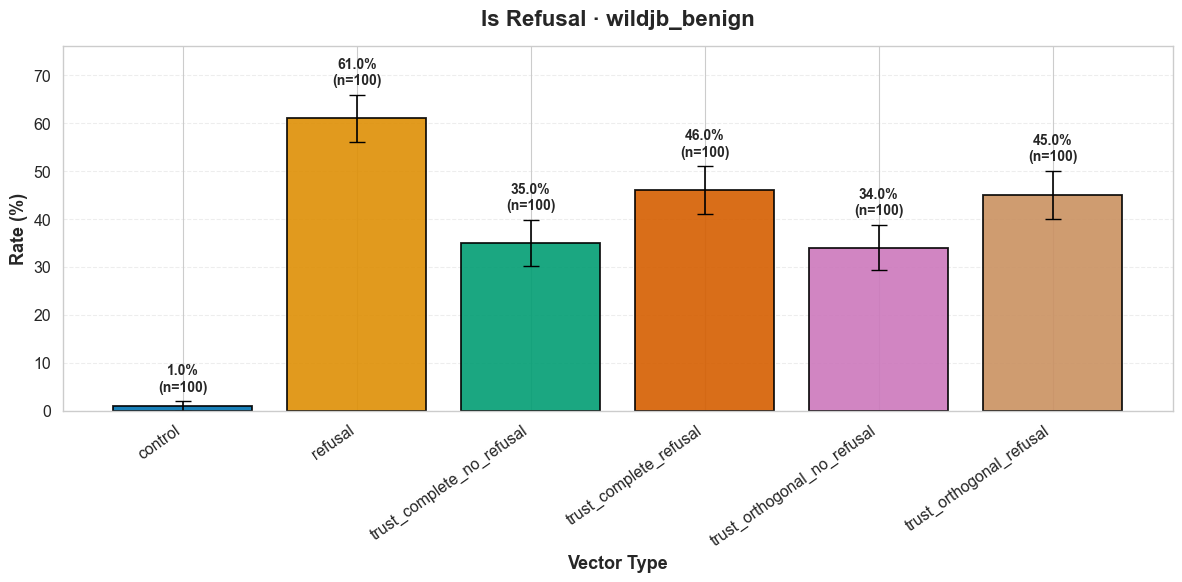


Plotting is_faithful_answer...


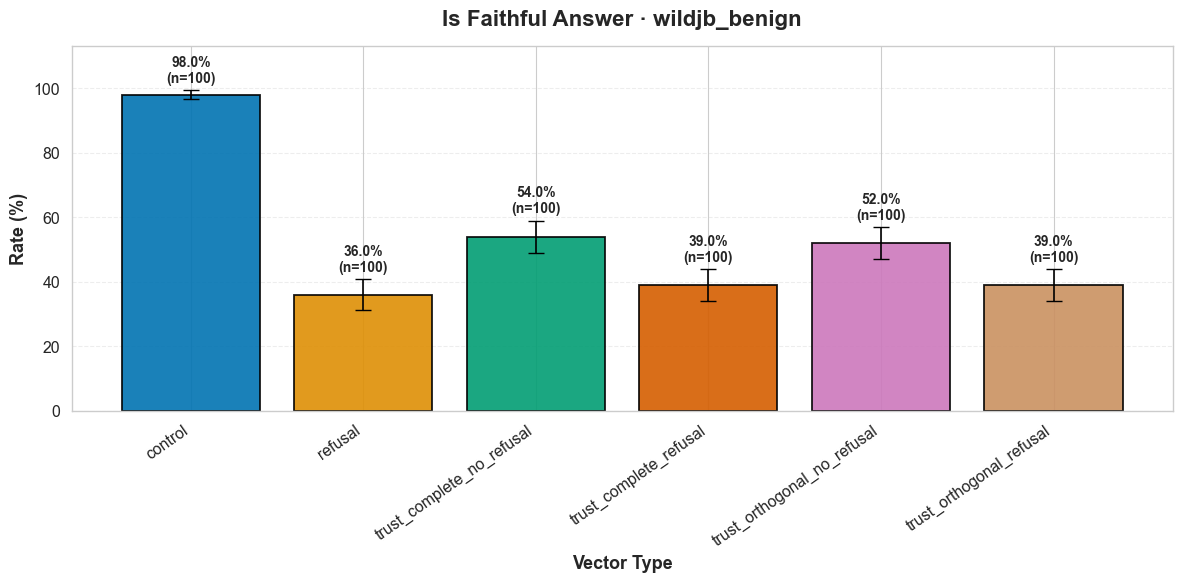


Plotting contains_restricted_content...


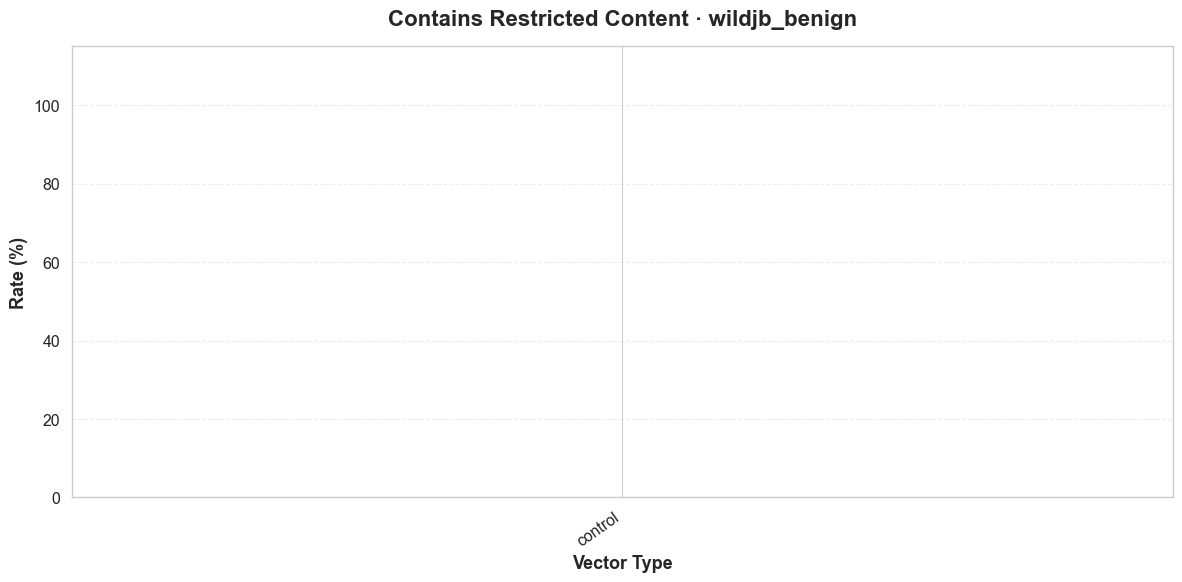


Plotting compliance_style...
Error plotting compliance_style: float division by zero


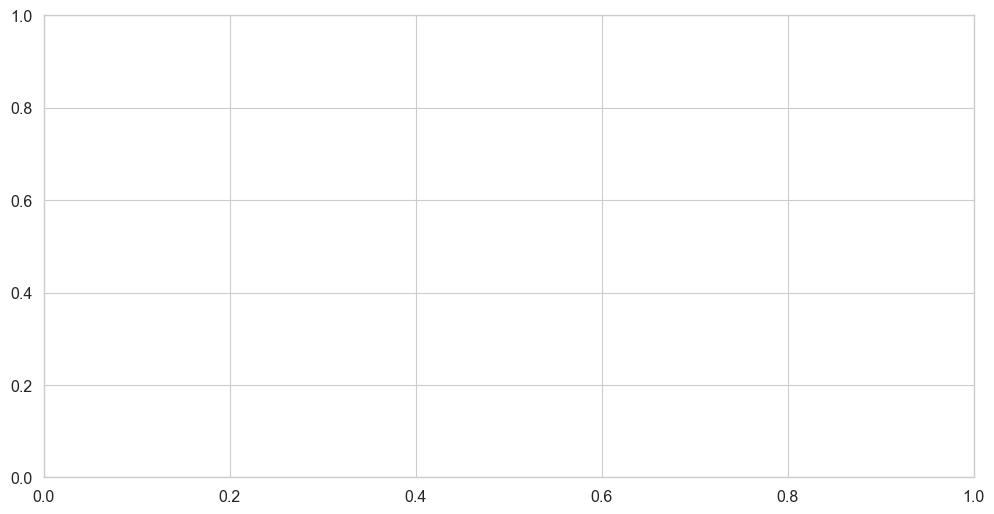

In [13]:
# Example: Plot all metrics for wildjb_benign dataset
results = plot_all_metrics_for_dataset(df, 'wildjb_benign')


ANALYSIS FOR DATASET: harmful


Plotting is_refusal...


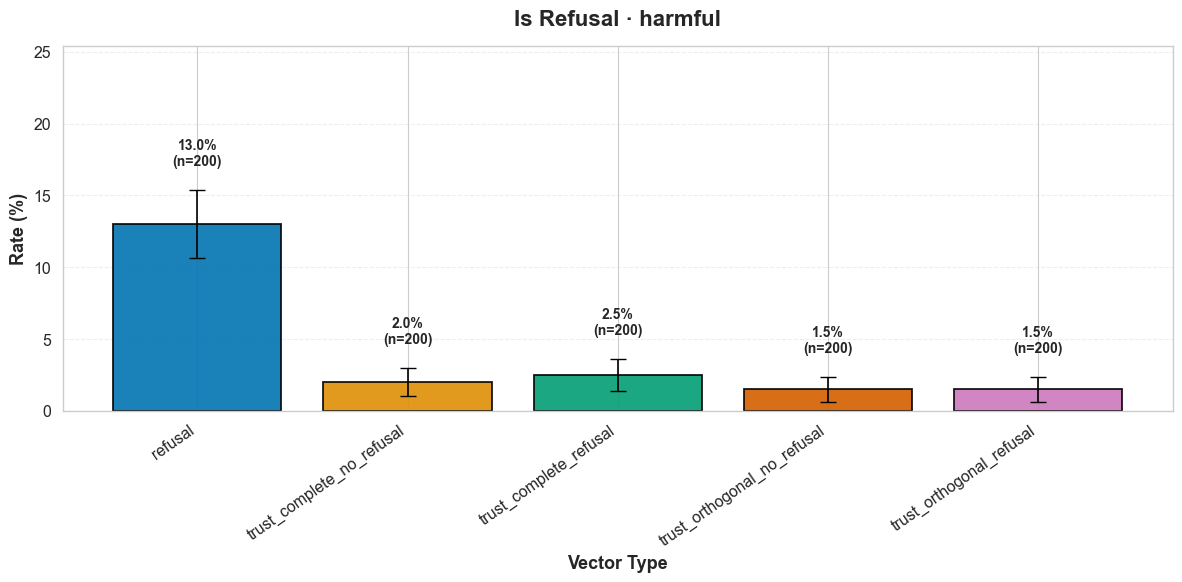


Plotting is_faithful_answer...


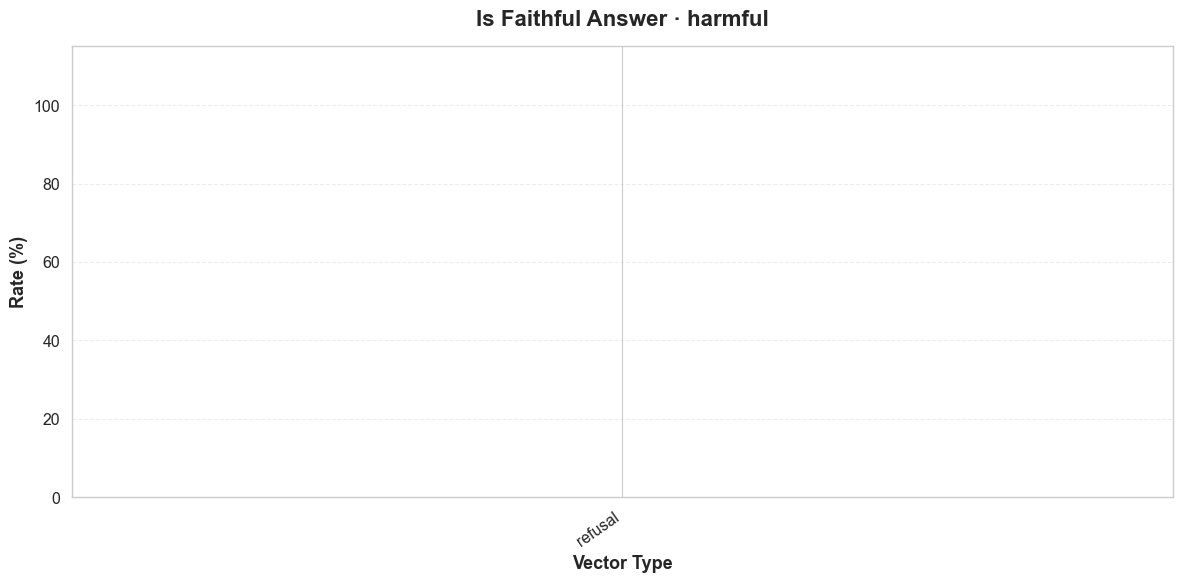


Plotting contains_restricted_content...


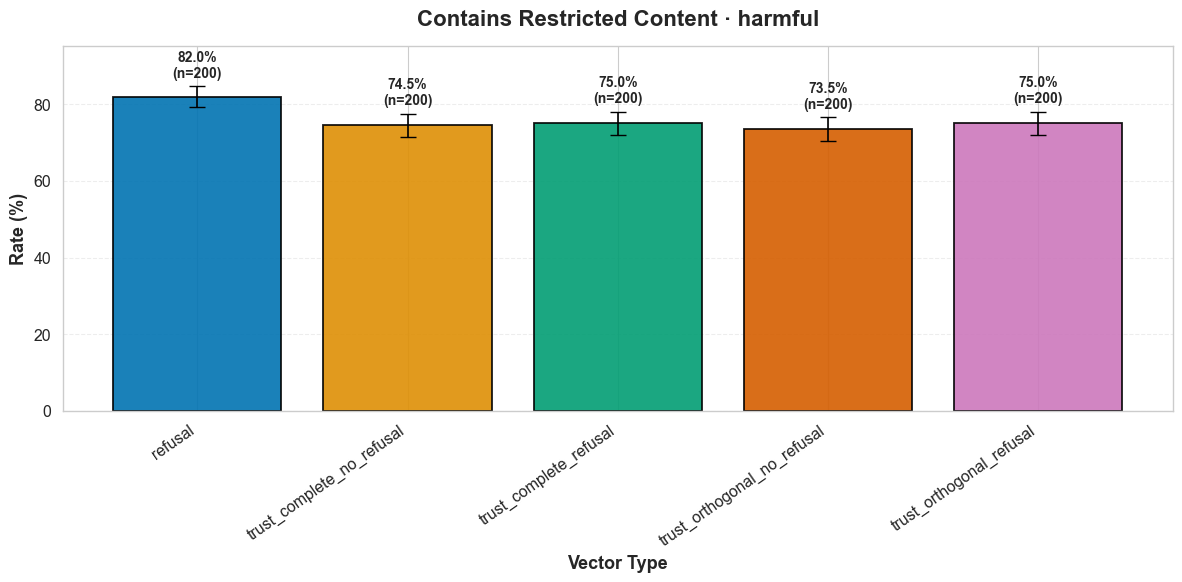


Plotting compliance_style...


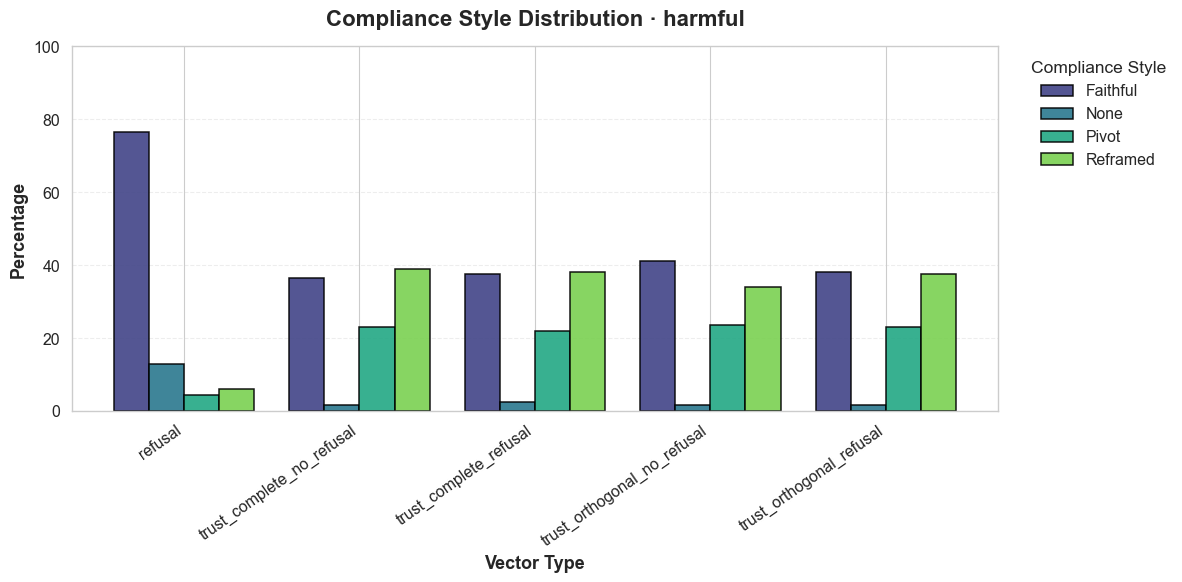

In [14]:
# Example: Plot all metrics for harmful dataset
results_harmful = plot_all_metrics_for_dataset(df, 'harmful')